# Kalman Filter

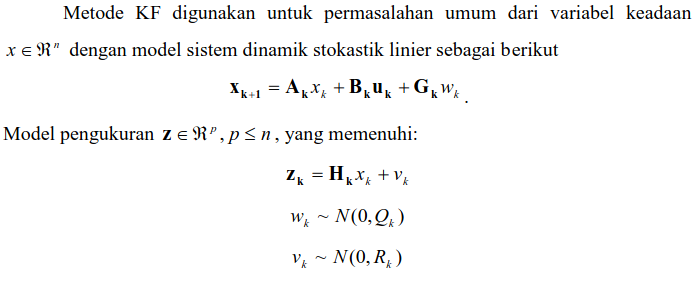

Secara umum KF memiliki dua tahapan yaitu:
1. Tahap Prediksi (time update)
2. Tahap Koreksi  (measurement update)


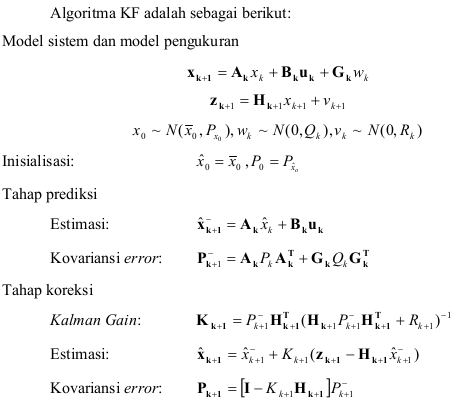

## Unscented Kalman Filter
metode UKF dalam proses estimasinya diawali dengan unscented transformation sebelum diimplementasikan ke dalam algoritma UKF itu sendiri.

### Unscented Transformation
Unscented Transformation (UT) merupakan sebuah metode untuk menghitung mean dan kovariansi dari sebuah variabel acak yang mengalami transformasi nonlinier. Misalkan diberikan sebuah model sistem stokastik nonlinier dan model pengukuran dengan noise yg bersifat aditif:
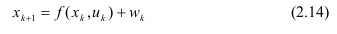


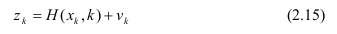

#### Non-augmented Unscented Transformation
Non-augmented Unscented Transformation merupakan unscented transformation dari variabel keadaan x k berdimensi- N x yang didekati dengan 2 Nx + 1 titik sigma xi berdasar persamaan dibawah ini:

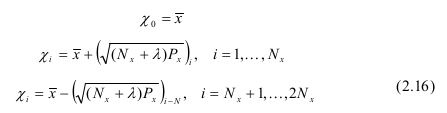

#### Augmented Unscented Transformation
Augmented Unscented Transformation adalah unscented transformation yang menggunakan variabel keadaan yang diperbesar. Dari persamaan (2.14) dan (2.15), diperoleh sistem yang diperbesar seperti berikut.
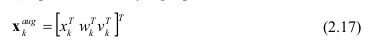
                            dengan dimensi N = Nx+Nw+Nv dan kovariansi sebagai berikut.


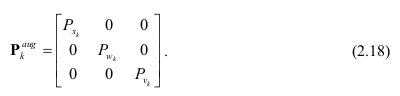

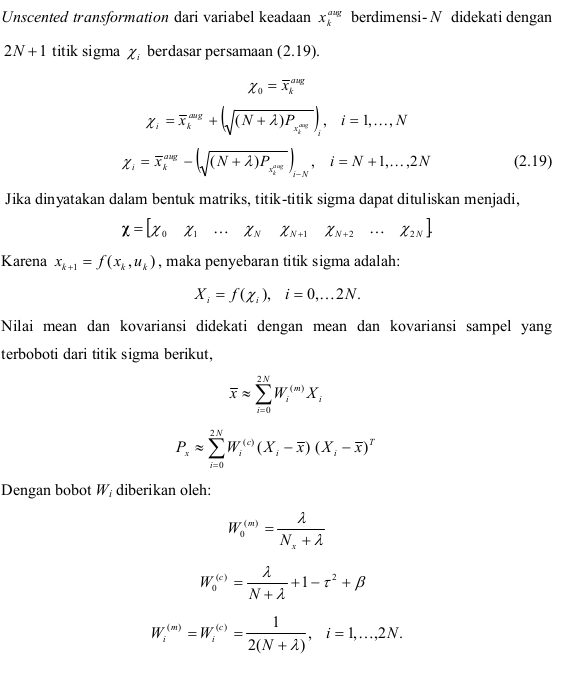

#### Algoritma Unscented Kalman Filter
Unscented Kalman Filter merupakan perluasan dari unscented transformation.Pada tahap inisialisasi didefinisikan sistem yang diperbesar dari persamaan (2.14) dan (2.15) seperti pada persamaan (2.17) beserta matriks kovariansei yang dituliskan pada persamaan (2.18). Kemudian dilanjutkan dengan pembentukan matriks titik sigma berdasar persamaan (2.19). Titik-titik sigma yang terbentuk itulah yang akan diestimasi pada tahap prediksi dan koreksi.


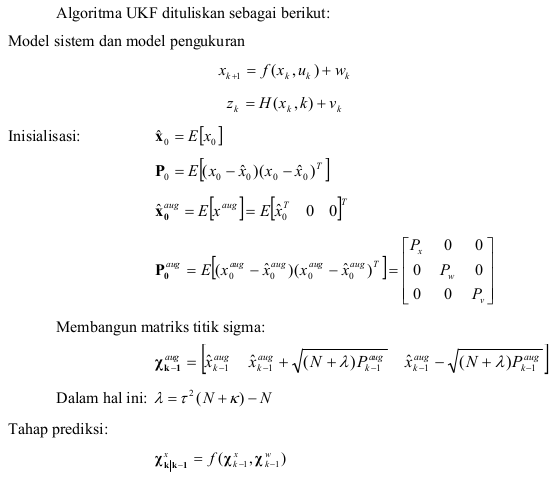

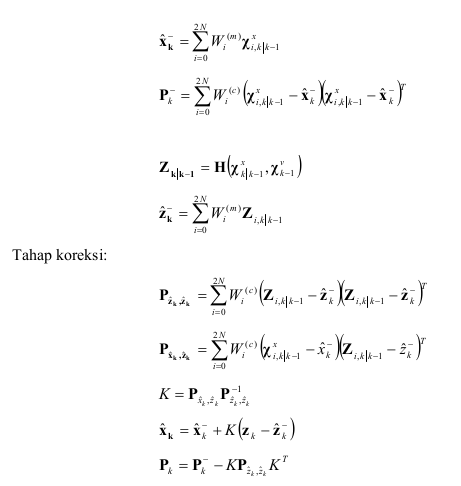

In [1]:
import cv2
import math
import numpy
import pykalman

In [2]:
class System:
    
    def __init__(self):
        # true target and sensor positions
        self.target = numpy.float32((256, 256))
        self.sensors = numpy.float32([(128, 128), (384, 384), (384, 128)])

        cv2.namedWindow('UKF')
        cv2.setMouseCallback('UKF', self.mouse_callback)

    # generates an observation vector
    # [|p - s0|, |p - s1|, ..., |p - sn|] + noise
    def measurement(self):
        dists = numpy.linalg.norm(self.sensors - self.target, axis=1)
        return dists + numpy.abs(numpy.random.normal(0.0, 25.0, dists.size))

    # updates the target position
    def mouse_callback(self, event, x, y, flags, userdata):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.pushed = True
        elif event == cv2.EVENT_LBUTTONUP:
            self.pushed = False

        if hasattr(self, 'pushed') and self.pushed:
            self.target = numpy.float32((x, y))

    # draw
    def draw(self, filter, measurement):
        canvas = numpy.ones((512, 512, 3), dtype=numpy.uint8) * 255

    # draw sensors and observations
        for r, sensor in zip(measurement, self.sensors):
            cv2.circle(canvas, tuple(sensor.astype(numpy.int32)), 5, (0, 255, 0), 2)
            cv2.circle(canvas, tuple(sensor.astype(numpy.int32)), int(r), (128, 128, 128), 1)

    # draw true target position
        cv2.circle(canvas, tuple(self.target.astype(numpy.int32)), 2, (255, 0, 0), 2)
        print("+++++++++++++++++++++++++++++++++++++")
        print("target",self.target)

# draw estimated target position and error ellipse
        cv2.circle(canvas, tuple(filter.mean.astype(numpy.int32)), 5, (0, 0, 255), 2)
        eigenvalues, eigenvectors = numpy.linalg.eig(filter.cov)
        idx = [x[0] for x in sorted(enumerate(eigenvalues), key=lambda x: x[1])]
        angle = math.degrees(math.atan2(eigenvectors[0, idx[1]], eigenvectors[1, idx[1]]))
        axes = (int(eigenvalues[idx[1]]), int(eigenvalues[idx[0]]))
        cv2.ellipse(canvas, tuple(filter.mean.astype(numpy.int32)), axes, angle, 0, 360, (0, 0, 255))
        print("angle", angle)
        print("axes", axes)

        print("+++++++++++++++++++++++++++++++++++++")
        cv2.imshow('UKF', canvas)


In [3]:
class Filter:
    def __init__(self, sensors):
        self.sensors = sensors

        # initialize ukf
        trans_cov = numpy.eye(2) * 20                 # transition noise covariance matrix
        obs_cov = numpy.eye(sensors.shape[0]) * 100   # observation noise covariance matrix
        self.mean = numpy.random.normal(256, 256, 2)  # initial mean
        self.cov = numpy.eye(2) * 128                 # initial covariance
        # In this system, we assume simple additive noises. So, AdditiveUnscentedKalmanFilter is more suitable (fast and robust).
        # But, you can use the usual UKF which doesn't assume such additive noises as well.
        # self.ukf = pykalman.UnscentedKalmanFilter(self.transition, self.observation, trans_cov, obs_cov, self.mean, self.cov)
        self.ukf = pykalman.AdditiveUnscentedKalmanFilter(self.transition_, self.observation_, trans_cov, obs_cov, self.mean, self.cov)
        print("transition noise covariance matrix", trans_cov)
        print("observation noise covariance matrix", obs_cov)
        print("initial mean", self.mean)
        print("initial covariance", self.cov)

    # transition function for Additive UKF
    # constant position
    def transition_(self, state):
        return state

    # observation function for Additive UKF
    # expected range data
    def observation_(self, state):
        expected = numpy.linalg.norm(self.sensors - state, axis=-1)
        return expected

    # transition function for usual UKF
    def transition(self, state, noise):
        return state + noise

    # observation function for usual UKF
    def observation(self, state, noise):
        expected = numpy.linalg.norm(self.sensors - state, axis=-1)
        return expected + noise

    # update state using ukf
    def update(self, measurement):
        self.mean, self.cov = self.ukf.filter_update(self.mean, self.cov, measurement)
        print("=================================================")
        print("mean", self.mean)
        print("cov", self.cov)
        print("=================================================")


In [4]:
# entry point
def main():
    system = System()
    filter = Filter(system.sensors)

    while cv2.waitKey(50) != 0x1b:
        obs = system.measurement()
        filter.update(obs)
        system.draw(filter, obs)
        print("obs", obs)

In [5]:
if __name__ == '__main__':
    main()

transition noise covariance matrix [[20.  0.]
 [ 0. 20.]]
observation noise covariance matrix [[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]]
initial mean [485.84706381 -27.45843754]
initial covariance [[128.   0.]
 [  0. 128.]]
mean [414.9959318   45.42950551]
cov [[70.28272502 29.92737271]
 [29.92737271 53.21802839]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 52.956473592978185
axes (92, 30)
+++++++++++++++++++++++++++++++++++++
obs [201.01405198 217.28769601 211.67370612]
mean [386.61470211  63.73415661]
cov [[52.06656918 17.85302276]
 [17.85302276 34.58495232]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 58.043144248262486
axes (63, 23)
+++++++++++++++++++++++++++++++++++++
obs [186.65018416 181.43577255 186.02426804]
mean [351.96337969  52.85351762]
cov [[43.44241408  8.4039096 ]
 [ 8.4039096  26.37343987]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 67.72084120857804
axes (46, 22)
+++++++++++++++++++++++++++++++++++

mean [241.50975118 267.99020512]
cov [[29.4723328  -5.87870982]
 [-5.87870982 29.1709369 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 134.26578567408046
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [188.05494061 211.18736353 186.48269465]
mean [244.03810883 262.29852916]
cov [[29.35092297 -5.96826402]
 [-5.96826402 29.35836638]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 135.01786432506546
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [185.67188835 198.97566344 181.30459158]
mean [254.19951848 272.45802544]
cov [[29.26853422 -6.10458722]
 [-6.10458722 29.5590581 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 135.68156335508758
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [242.38383506 188.58358675 188.90145392]
mean [241.26833416 274.46994499]
cov [[29.78124245 -6.17769547]
 [-6.17769547 29.12820826]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 133.48724659572983
axes (35, 23)

angle 134.07914017918569
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [187.74359964 207.68279767 185.40003486]
mean [239.89933197 268.96952101]
cov [[29.38865062 -6.10160985]
 [-6.10160985 29.43596706]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 135.1110780132071
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [192.13629268 195.5286542  212.36660205]
mean [239.81012768 269.18507746]
cov [[29.30891091 -6.01311896]
 [-6.01311896 29.46014704]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 135.36024296563798
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [182.48800965 186.49901146 201.81531309]
mean [239.65816264 265.63524486]
cov [[29.2774074  -5.97582496]
 [-5.97582496 29.45825298]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 135.43345051297126
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [198.09958948 213.69189657 189.7797759 ]
mean [247.4829068  273.66073959]
cov [[29.19829083 -6.01629274]
 [

mean [247.10799137 276.33963459]
cov [[29.28643141 -5.94147733]
 [-5.94147733 29.44333973]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 135.3782587044356
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [225.79042748 190.38200437 187.847801  ]
mean [248.8868262  273.32090218]
cov [[29.5887128  -5.96445228]
 [-5.96445228 29.13982665]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 133.92248479853376
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [203.81490913 191.10592639 188.86030461]
mean [242.1464744  268.90428764]
cov [[29.7121285  -6.04008228]
 [-6.04008228 29.07536013]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 133.49131173572565
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [181.41828417 201.07658141 200.99244237]
mean [245.39847375 268.50113801]
cov [[29.47687034 -6.02425317]
 [-6.02425317 29.29788328]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 134.57445144689234
axes (35, 23)


mean [219.10412069 280.26148849]
cov [[28.76216178 -5.08828738]
 [-5.08828738 29.20726821]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 136.25221287984982
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
obs [186.21162    196.12352093 229.5516699 ]
mean [229.25177519 272.26362418]
cov [[28.6836765  -4.92057795]
 [-4.92057795 29.15683832]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 136.37632784775732
axes (33, 23)
+++++++++++++++++++++++++++++++++++++
obs [183.44829897 195.51509839 184.96354595]
mean [231.34212587 262.21007722]
cov [[28.78664096 -5.31954128]
 [-5.31954128 29.31254652]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 136.41495576564694
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
obs [181.42183529 220.89107121 181.19404092]
mean [233.88415755 268.10314077]
cov [[28.74044354 -5.7224583 ]
 [-5.7224583  29.69741848]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 137.38985465174648
axes (34, 23)

mean [240.90770522 268.10186729]
cov [[29.22847742 -5.75845252]
 [-5.75845252 29.25150011]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 135.0572680337437
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
obs [194.24119073 202.80464884 193.23764361]
mean [234.8837221  272.61847157]
cov [[29.2451661  -5.91141021]
 [-5.91141021 29.38523964]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 135.3393964827603
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [212.3770009  221.07013986 214.26002662]
mean [243.08888493 280.65579447]
cov [[29.17127162 -5.78918274]
 [-5.78918274 29.3892922 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 135.53937590869415
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
obs [225.4389409  182.33322433 201.14826916]
mean [246.64605656 278.96849899]
cov [[29.45642449 -5.75839404]
 [-5.75839404 29.07884269]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 134.0611055138878
axes (35, 23)
++

+++++++++++++++++++++++++++++++++++++
target [422. 275.]
angle 108.4790097585371
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
obs [343.14930211 133.72717229 170.52711566]
mean [448.14907562 262.59303452]
cov [[34.47113325 -4.15074466]
 [-4.15074466 24.91776646]]
+++++++++++++++++++++++++++++++++++++
target [422. 275.]
angle 110.49466029621885
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
obs [330.61271967 176.76535172 168.38268053]
mean [457.74305268 270.30480665]
cov [[32.94596349 -4.16189577]
 [-4.16189577 25.60957743]]
+++++++++++++++++++++++++++++++++++++
target [422. 275.]
angle 114.30391869218099
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
obs [372.75398086 135.2087903  175.58222904]
mean [453.11584111 275.45314151]
cov [[31.3710624  -3.98552322]
 [-3.98552322 26.44681767]]
+++++++++++++++++++++++++++++++++++++
target [422. 275.]
angle 119.1468103457749
axes (33, 24)
+++++++++++++++++++++++++++++++++++++
obs [338.17691871 128.91914815 183.25382121]
mean [447.

mean [182.27399328 241.37560848]
cov [[27.77694089 -5.09559785]
 [-5.09559785 30.34498185]]
+++++++++++++++++++++++++++++++++++++
target [203. 232.]
angle 142.07165073024066
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
obs [132.46012875 255.26681312 219.46299686]
mean [198.0069542  229.46631065]
cov [[27.75105302 -5.28495548]
 [-5.28495548 30.48706773]]
+++++++++++++++++++++++++++++++++++++
target [251. 158.]
angle 142.25622333738812
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
obs [180.39473124 308.86597955 142.17137413]
mean [207.01587547 222.73756046]
cov [[27.57238877 -6.30277457]
 [-6.30277457 31.60078289]]
+++++++++++++++++++++++++++++++++++++
target [251. 158.]
angle 143.86124004159228
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
obs [144.4359337  263.9316209  173.01069823]
mean [210.63718788 216.98957497]
cov [[27.37811457 -7.04784085]
 [-7.04784085 32.75419044]]
+++++++++++++++++++++++++++++++++++++
target [251. 158.]
angle 145.43839516394894
axes (37, 22)

mean [417.63909707  88.72007601]
cov [[35.26438263  8.31758094]
 [ 8.31758094 27.08367249]]
+++++++++++++++++++++++++++++++++++++
target [393.  98.]
angle 58.093338383844916
axes (40, 21)
+++++++++++++++++++++++++++++++++++++
obs [310.97813976 297.55024496  35.46961433]
mean [406.75861546  79.37610792]
cov [[33.74198401  9.45958128]
 [ 9.45958128 29.32568704]]
+++++++++++++++++++++++++++++++++++++
target [393.  98.]
angle 51.56963289015171
axes (41, 21)
+++++++++++++++++++++++++++++++++++++
obs [274.37817176 338.22207755  32.75704998]
mean [413.26584435  81.42082163]
cov [[35.37908958  8.88011468]
 [ 8.88011468 27.6729606 ]]
+++++++++++++++++++++++++++++++++++++
target [393.  98.]
angle 56.72796407253565
axes (41, 21)
+++++++++++++++++++++++++++++++++++++
obs [301.64684232 300.63200327  54.35957437]
mean [404.9161293   83.76300342]
cov [[35.23655583  9.42712055]
 [ 9.42712055 28.27606792]]
+++++++++++++++++++++++++++++++++++++
target [393.  98.]
angle 55.13140721549171
axes (41, 21)
++

mean [244.43608325 154.2176912 ]
cov [[22.95374143 -7.14962208]
 [-7.14962208 44.6315829 ]]
+++++++++++++++++++++++++++++++++++++
target [245. 172.]
angle 163.29508081652358
axes (46, 20)
+++++++++++++++++++++++++++++++++++++
obs [151.92165523 262.42247444 171.36912939]
mean [243.72162779 158.58002468]
cov [[23.09887832 -7.13699309]
 [-7.13699309 44.09086701]]
+++++++++++++++++++++++++++++++++++++
target [245. 172.]
angle 162.8926772519264
axes (46, 20)
+++++++++++++++++++++++++++++++++++++
obs [126.81510229 261.57876616 153.27146651]
mean [247.83363917 157.41343245]
cov [[23.26531744 -7.20634225]
 [-7.20634225 43.56986464]]
+++++++++++++++++++++++++++++++++++++
target [245. 172.]
angle 162.31594877475712
axes (45, 20)
+++++++++++++++++++++++++++++++++++++
obs [147.24743036 274.44992533 147.79287978]
mean [250.7804021  208.05484407]
cov [[23.26770145 -6.99257725]
 [-6.99257725 43.12551053]]
+++++++++++++++++++++++++++++++++++++
target [257. 322.]
angle 162.42215714653838
axes (45, 21)


mean [115.94840831 320.36481111]
cov [[27.27457542  3.60563023]
 [ 3.60563023 29.67486976]]
+++++++++++++++++++++++++++++++++++++
target [134. 310.]
angle -144.20510482970477
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
obs [191.67770762 279.90367594 331.91447699]
mean [122.14432514 324.60919918]
cov [[27.22176143  3.71446578]
 [ 3.71446578 29.80751583]]
+++++++++++++++++++++++++++++++++++++
target [134. 310.]
angle -144.59562072622828
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
obs [206.8829325  261.11483778 320.19102711]
mean [123.71617166 327.77391058]
cov [[27.31428083  3.61070677]
 [ 3.61070677 29.65440161]]
+++++++++++++++++++++++++++++++++++++
target [134. 310.]
angle -143.97753643098778
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
obs [204.2922457  262.14458949 329.59620777]
mean [120.20390807 332.91080683]
cov [[27.39508288  3.6051908 ]
 [ 3.6051908  29.55074964]]
+++++++++++++++++++++++++++++++++++++
target [134. 310.]
angle -143.32246684046203
axes (32,